# Credits

* **Author** : Aurelio Murolo ;
* **Date** : March, 2025 ;
* **Git-Hub** : [University Project Repository](https://github.com/AurelioMurolo/University-Projects) .

# Modules Import & Agnostic Device Setting



In [1]:
# Data & Plots
import sklearn
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from pathlib import Path
import random

if Path("helper_function.py").is_file():
  print("Already exists")
else:
  requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(requests.content)

from helper_function import plot_loss_curves, plot_decision_boundary

# Model
import torch
!pip install -q torchmetrics
from torch import nn
from torchmetrics.classification import BinaryAccuracy

!pip install -q torchinfo
from torchinfo import summary

Already exists


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The available device is: ", device)

The available device is:  cpu


# Code Reproducibility

In according to the official documentation about [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html):

> As long as `torch.manual_seed()` is set to a constant at the beginning of an application and all **other sources of nondeterminism** have been eliminated, the same series of random numbers will be generated each time the application is run in the same environment.

The other sources of nondeterminism include both the seeds of other libraries and the intrinsical randomness of the algorithms used by Pytorch for its operations.

Although a good reproducibility may cause a decrese both in performances and speed, it gurantees the optimal condition for the experimentations, Galileo Galilei *docet* . In order to decrees the non - deterministic behaviour we can run the following line of code.





In [3]:
seed = 42

# Torch
torch.manual_seed(seed)  # Seed for both CPU and GPU
torch.cuda.manual_seed(seed)  # Seed for GPU random number generation
torch.cuda.manual_seed_all(seed)  # For multi-GPU

torch.backends.cudnn.benchmark = True  # Deterministically select an algorithm
torch.backends.cudnn.deterministic = True # if only nondeterministic algorithms are available they will throw a RuntimeError when called
torch.Generator().manual_seed(42)  # Seed for batch shuffling

# Numpy
np.random.seed(seed)

# Python
random.seed(seed)

You can find the full list of the normally-nondeterministic operations that will act deterministically when `torch.backends.cudnn.deterministic = True` at the following [link](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms) .

In the end it's important to underline that it sufficient to call all the above functions only once at the beginning of the script, especially on a Jupyter Notebook like this where sometimes there are some "mis-comunication" among the cell of code. Anyway as you will se i still called them toI do it to avoid any possible problems.

# Toy DataSet Import

In [4]:
def DataGeneration(n_samples : int, noise : float, random_state : int, plot: bool):
  X, y = make_circles(n_samples = n_samples, noise = noise, random_state = random_state)
  if plot :
    plt.scatter(X[:,0], X[:,1]  ,c = y, cmap = plt.cm.RdYlBu, s = 10)
    plt.title(f'Circles with noise : {noise}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

  return X, y

Lets'see how data looklike if we increse the *Gaussian noise* parameter.

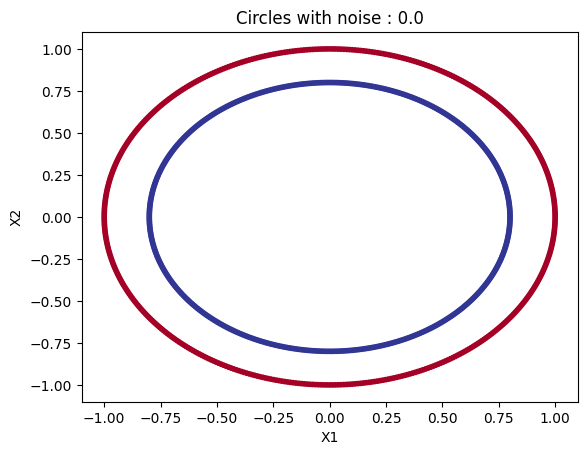

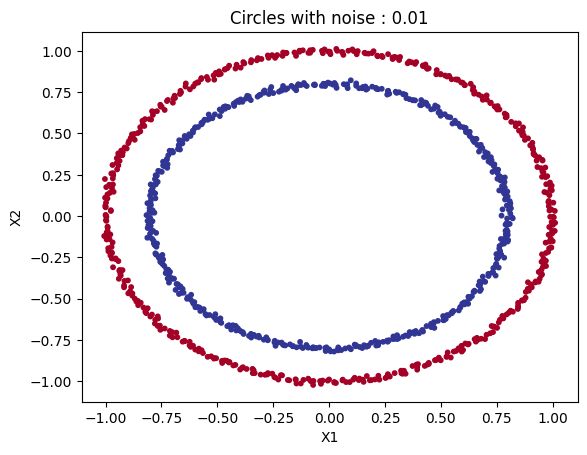

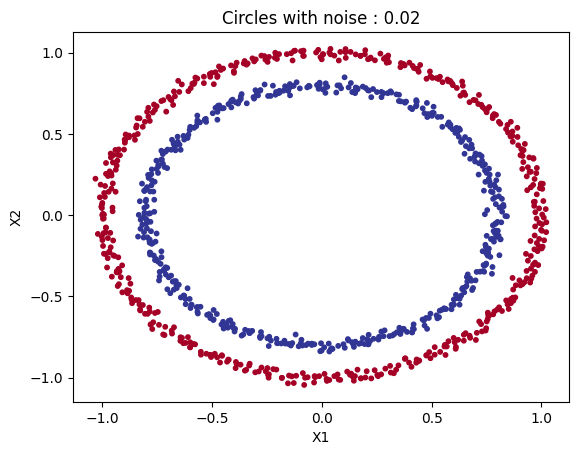

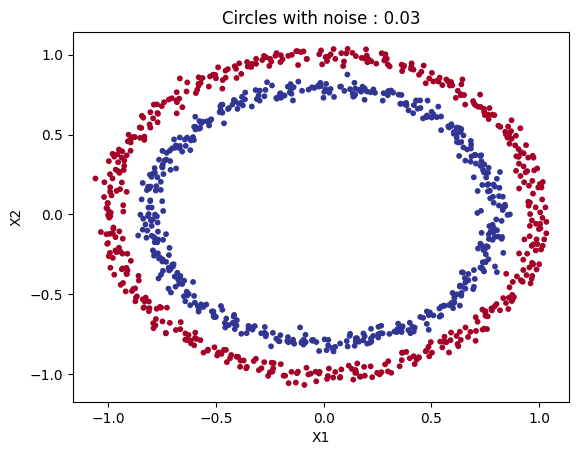

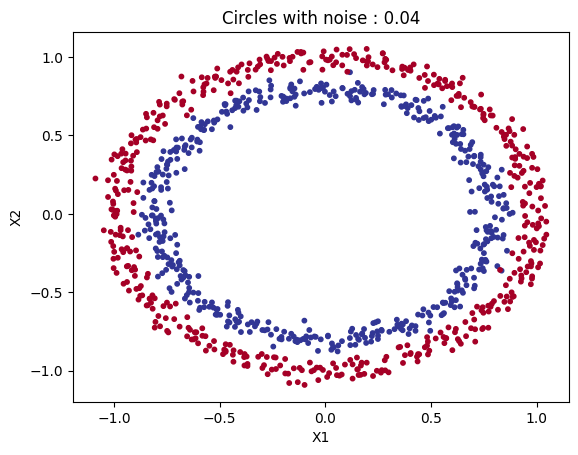

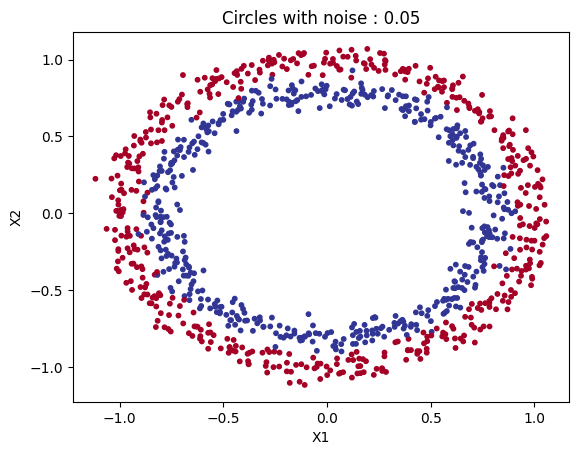

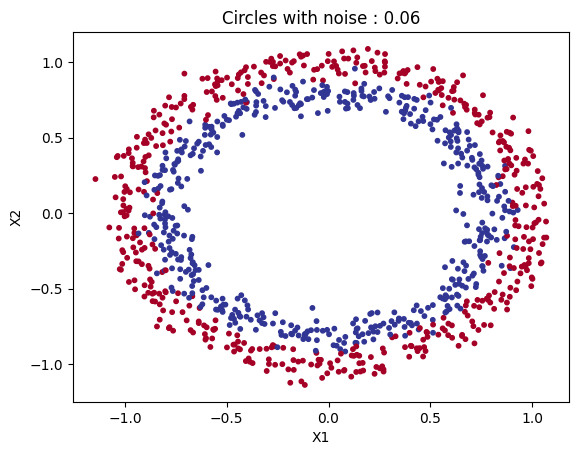

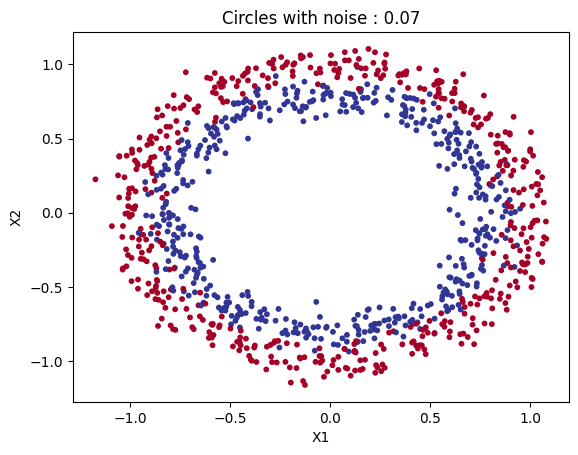

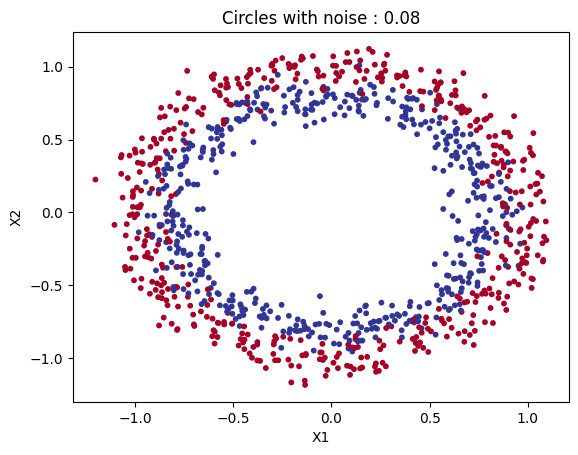

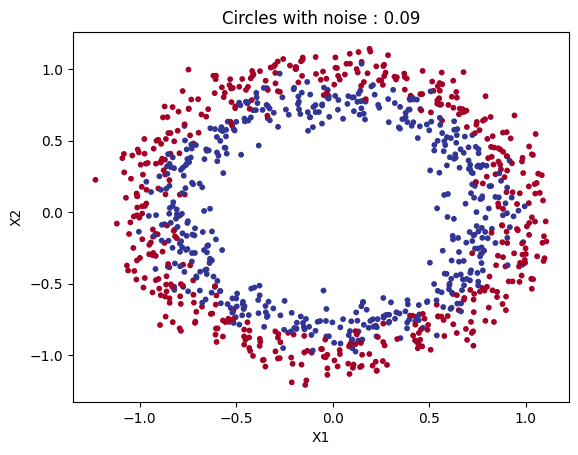

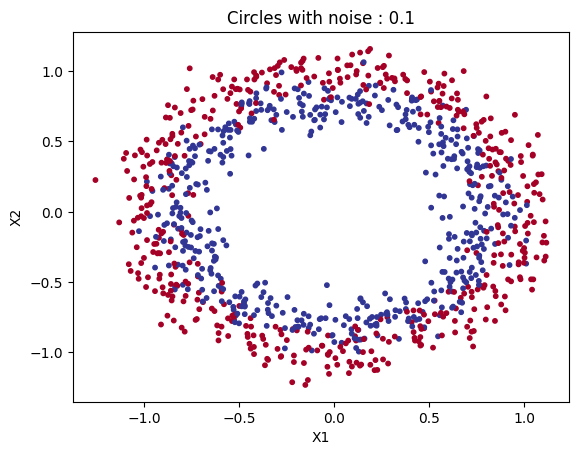

In [5]:
noise_array = np.arange(0, 0.11, 0.01)
for inc_noise in noise_array:
  DataGeneration(n_samples = 1000, noise = float(inc_noise), random_state = seed, plot = True)

As first approach i will consider the case `noise = 0.02` .






In [6]:
X, y = DataGeneration(n_samples = 1000, noise = 0.02, random_state = seed, plot = False)

# Binary Classifier

## Architecture & Evaluation Metrics

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of nn.Module).
2. Creates $5$ `nn.Linear` layers in the constructor capable of handling the input and output shapes of **X** and **y**.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [7]:
class FeedForward_NN(nn.Module):
  def __init__(self, input_units : int, output_units : int, hidden_units_1 : int, hidden_units_2 : int, hidden_units_3 : int, hidden_units_4 : int):
    super().__init__()

    # Number of Nodes
    self.input_units = input_units

    self.hidden_units_1 = hidden_units_1
    self.hidden_units_2 = hidden_units_2
    self.hidden_units_3 = hidden_units_3
    self.hidden_units_4 = hidden_units_4
    self.output_units = output_units

    # Architecture
    self.input_layer = nn.Linear(self.input_units, self.hidden_units_1)
    self.hidden_layer_1 = nn.Linear(self.hidden_units_1, self.hidden_units_2)
    self.hidden_layer_2 = nn.Linear(self.hidden_units_2, self.hidden_units_3)
    self.hidden_layer_3 = nn.Linear(self.hidden_units_3, self.hidden_units_4)
    self.output_layer = nn.Linear(self.hidden_units_4, self.output_units)

    #self.relu = nn.ReLU()
    self.relu = nn.LeakyReLU(negative_slope = 0.01)


  def forward(self, x):

    #Z_1 = self.relu(self.input_layer(x))
    #Z_2 = self.relu(self.hidden_layer_1(Z_1))
    #Z_3 = self.relu(self.hidden_layer_2(Z_2))
    #Z_4 = self.relu(self.hidden_layer_3(Z_3))
    #Z_5 = self.output_layer(Z_4)

    x = self.relu(self.input_layer(x))
    x = self.relu(self.hidden_layer_1(x))
    x = self.relu(self.hidden_layer_2(x))
    x = self.relu(self.hidden_layer_3(x))
    x = self.output_layer(x)

    return x #raw logits for BCEWithLogitsLoss

In according to the PyTorch workflow, one can also put sigmoid in the model as activation function, but this would mean you don't need to use it on the predictions. The mapping from logits happens in a second phase.

In [8]:
input_dimension = X.shape[1]

In [9]:
Five_layer_model_NN = FeedForward_NN(input_units =  input_dimension,
                                     output_units = 1,                     # Binary Classification
                                     hidden_units_1 = 3 * input_dimension, # d_model >> d_in
                                     hidden_units_2 = 3 * input_dimension,
                                     hidden_units_3 = 2 * input_dimension,
                                     hidden_units_4 = 2 * input_dimension).to(device)

In [10]:
Five_layer_model_NN

FeedForward_NN(
  (input_layer): Linear(in_features=2, out_features=6, bias=True)
  (hidden_layer_1): Linear(in_features=6, out_features=6, bias=True)
  (hidden_layer_2): Linear(in_features=6, out_features=4, bias=True)
  (hidden_layer_3): Linear(in_features=4, out_features=4, bias=True)
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [11]:
Five_layer_model_NN.state_dict() # Initial Condition Before Training

OrderedDict([('input_layer.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323]])),
             ('input_layer.bias',
              tensor([ 0.5224,  0.0958,  0.3410, -0.0998,  0.5451,  0.1045])),
             ('hidden_layer_1.weight',
              tensor([[-0.1906,  0.1041, -0.1881, -0.0479, -0.1658,  0.2708],
                      [-0.3223, -0.1882, -0.1153, -0.2455,  0.0385, -0.4032],
                      [ 0.3687, -0.3468,  0.3152,  0.0679, -0.1326,  0.2523],
                      [ 0.0636,  0.3298,  0.0446, -0.1288,  0.1097, -0.1107],
                      [ 0.1718,  0.3645,  0.2360, -0.1785,  0.2357,  0.0730],
                      [ 0.2073, -0.2488, -0.4041, -0.1577, -0.3131,  0.3350]])),
             ('hidden_layer_1.bias',
              tensor([ 0.1176,  0.1691,  0.1291, 

Remember that although there are $4$ different layer, the architecture still have $5$ layer, the last one will be added in the nex cell of code. It just an architectural choice to take advantage of the optimized loss defined for logits.

As reported in the official documentation :


> This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.



In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(Five_layer_model_NN.parameters(), lr = 0.001)

As evaluation metric we will simply consider the accuracy defined as :

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Alternatively we can also use the one defined in the `torchmetrics` class from [lightning AI](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html) :

In [14]:
acc_metric = BinaryAccuracy(threshold = 0.5).to(device)

### User-Friendly Model construction

Since the model is pretty simple, we can make it more user - friendly by using the class `nn.Sequential()` and the `input()` function.

In [15]:
class Sequential_FeedForward_NN(nn.Module):
    def __init__(self, input_units: int, output_units: int, hidden_layers: list, activation_func="leaky_relu"):
        super().__init__()

        # Define activation functions as a dictionary for easy selection
        activations = {"relu": nn.ReLU(),
                       "leaky_relu": nn.LeakyReLU(negative_slope=0.01),
                       "sigmoid": nn.Sigmoid(),
                       "tanh": nn.Tanh()}

        # Select activation function (default: LeakyReLU)
        activation = activations.get(activation_func.lower(), nn.LeakyReLU(negative_slope=0.01))

        # Create layers dynamically
        layers = []
        previous_units = input_units

        for units in hidden_layers:
            layers.append(nn.Linear(previous_units, units))
            layers.append(activation)
            previous_units = units  # This gurantees the correct shape of Weights matrices

        layers.append(nn.Linear(previous_units, output_units))  # Output layer

        self.model = nn.Sequential(*layers)  # Convert list to nn.Sequential

    def forward(self, x):
        return self.model(x)  # Pass input through the model to get logits


def get_user_inputs():
    """Function to get model parameters from the user interactively"""
    try:
        input_size = int(input("Enter the number of input features: "))
        output_size = int(input("Enter the number of output features: "))

        # Ensure valid hidden layers input
        while True:
            hidden_layers = input("Enter hidden layer sizes (comma-separated, e.g., 64,128,64): ")
            try:
                hidden_layers = [int(x) for x in hidden_layers.split(",")]
                if hidden_layers:
                    break
            except ValueError:
                print("Invalid input. Please enter a comma-separated list of integers.")

        #activation_func = input("Choose activation function (relu, leaky_relu, sigmoid, tanh): ").lower()
        while True:
            activation_func = input("Choose activation function (relu, leaky_relu, sigmoid, tanh): ").lower()
            try:
              if activation_func not in ["relu", "leaky_relu", "sigmoid", "tanh"]:
                raise ValueError
              else:
                break
            except ValueError:
              print("Invalid activation function. Insert one of the available function.")

        return input_size, output_size, hidden_layers, activation_func
    except ValueError:
        print("Invalid input! Please enter valid numerical values.")
        return get_user_inputs()  # Restart input collection if invalid




In [16]:
# Get user inputs
input_size, output_size, hidden_layers, activation_func = get_user_inputs()

# Create the model
model = Sequential_FeedForward_NN(input_size, output_size, hidden_layers, activation_func)

Enter the number of input features: 1
Enter the number of output features: 2
Enter hidden layer sizes (comma-separated, e.g., 64,128,64): 6,6,4,4
Choose activation function (relu, leaky_relu, sigmoid, tanh): leaky_relu


In [17]:
# Print model architecture
print("\nGenerated Model Architecture:\n")
print(model)


Generated Model Architecture:

Sequential_FeedForward_NN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=6, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=4, out_features=2, bias=True)
  )
)


For more complex models we would like to have a more granular visualizations of each component of the model, we will se how achive it in the  lets' se how we can achive it in the **Model Summary** section .

## Training & Test Loop

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)

X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

In [20]:
type(X_train), X_train.shape, type(y_train), y_train.shape

(torch.Tensor, torch.Size([800, 2]), torch.Tensor, torch.Size([800]))

It is foundamental to pass from ` numpy.ndarray ---> torch.Tensor `.






In [21]:
epochs = 500
batch_size = 128

In [22]:
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [23]:
# Define DataSet and DataLoader
Dataset = torch.utils.data.TensorDataset(X_train, y_train)
Dataset_loader = torch.utils.data.DataLoader(Dataset, batch_size = batch_size, shuffle = True)

# Inizialize the model and its optimizer for each training  Looop
torch.manual_seed(seed)
Five_layer_model_NN = FeedForward_NN(input_units =  input_dimension,
                                     output_units = 1,
                                     hidden_units_1 = 3 * input_dimension,
                                     hidden_units_2 = 3 * input_dimension,
                                     hidden_units_3 = 2 * input_dimension,
                                     hidden_units_4 = 2 * input_dimension).to(device)

optimizer = torch.optim.Adam(Five_layer_model_NN.parameters(), lr = 0.001)

# Training Loop
results = {'train_loss':[], 'train_acc': [], 'test_loss':[], 'test_acc': []}
for epoch in range(epochs + 1):
  for X_train_batch, y_train_batch in Dataset_loader:
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

    # 1. Training Mode & Forward pass
    Five_layer_model_NN.train()
    y_logits = Five_layer_model_NN.forward(X_train_batch).squeeze() # Output of the forward method
    y_pred = torch.round(torch.sigmoid(y_logits))                   # logits > 0.5 -> predicted label = 1

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train_batch)
    acc = accuracy_fn(y_true = y_train_batch, y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    ## Context Window for Testing to stop the evaluation of  parameters
    Five_layer_model_NN.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = Five_layer_model_NN(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    results['train_loss'].append(float(loss))
    results['train_acc'].append(float(acc))
    results['test_loss'].append(float(test_loss))
    results['test_acc'].append(float(test_acc))

  # Print out what's happening
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.09121, Accuracy: 100.00% | Test Loss: 0.13440, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.00844, Accuracy: 100.00% | Test Loss: 0.01243, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00143, Accuracy: 100.00% | Test Loss: 0.00580, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00120, Accuracy: 100.00% | Test Loss: 0.00336, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00106, Accuracy: 100.00% | Test Loss: 0.00224, Test Accuracy: 100.00%


The PyTorch workflow is :

1. **Forward pass** - The model goes through all of the training data once, performing its ```forward()``` function calculations (```model(x_train)```).
2. **Calculate the Loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (```loss = loss_fn(y_pred, y_train```).
3. **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (```optimizer.zero_grad()```).

4. Perform **Backpropagation** on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with ```requires_grad=True```). This is known as backpropagation, hence "backwards"  (```loss.backward()```).
5.  **Gradient Descent** - Update the parameters with ```requires_grad=True``` with respect to the loss gradients in order to improve them (```optimizer.step()```).

One can find an usefull guideline at the [**Zero to Mastery Learn PyTorch for Deep Learning**](https://www.learnpytorch.io/) course.

### Model Summary

Now, there exists one library called [torchsummary](https://pypi.org/project/torch-summary/) but, as you can read at the link, torch-summary has been renamed to [torchinfo]().

Torchinfo provides information complementary to what is provided by `print(your_model)` in PyTorch, similar to Tensorflow's `model.summary()` API to view the visualization of the model, which is helpful while debugging your network.

In [24]:
summary(Five_layer_model_NN,
        input_size=(batch_size, input_dimension),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        mode = 'eval',
        col_width = 20,
        depth = 3,
        row_settings=["var_names"],
        verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FeedForward_NN (FeedForward_NN)          [128, 2]             [128, 1]             --                   True
├─Linear (input_layer)                   [128, 2]             [128, 6]             18                   True
│    └─weight                                                                      ├─12
│    └─bias                                                                        └─6
├─LeakyReLU (relu)                       [128, 6]             [128, 6]             --                   --
├─Linear (hidden_layer_1)                [128, 6]             [128, 6]             42                   True
│    └─weight                                                                      ├─36
│    └─bias                                                                        └─6
├─LeakyReLU (relu)                       [128, 6]             [128, 6]             --                 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FeedForward_NN (FeedForward_NN)          [128, 2]             [128, 1]             --                   True
├─Linear (input_layer)                   [128, 2]             [128, 6]             18                   True
│    └─weight                                                                      ├─12
│    └─bias                                                                        └─6
├─LeakyReLU (relu)                       [128, 6]             [128, 6]             --                   --
├─Linear (hidden_layer_1)                [128, 6]             [128, 6]             42                   True
│    └─weight                                                                      ├─36
│    └─bias                                                                        └─6
├─LeakyReLU (relu)                       [128, 6]             [128, 6]             --                 

### What if we increse the threshold?

With the manual defined `accuracy_fn()` we implicitly assumed that the **threshold** was $0.5$. In general we can be more restrictive when transforming probability to binary $\{0,1\}$ predictions.

In the preceding code i did such assumption with the line:


```
 y_pred = torch.round(torch.sigmoid(y_logits)) # logits > 0.5 -> predicted label = 1
```

Now, lets' se what happen with a range of threshold.



In [25]:
threshold = np.arange(0.55, 0.95 + 0.10 , 0.10)

In [26]:
for t in threshold:
  acc_metric = BinaryAccuracy(threshold = t).to(device)
  # Define DataSet and DataLoader
  Dataset = torch.utils.data.TensorDataset(X_train, y_train)
  Dataset_loader = torch.utils.data.DataLoader(Dataset, batch_size = batch_size, shuffle = True)

  # Inizialize the model and its optimizer for each training  Looop
  torch.manual_seed(seed)
  Five_layer_model_NN = FeedForward_NN(input_units =  input_dimension,
                                      output_units = 1,
                                      hidden_units_1 = 3 * input_dimension,
                                      hidden_units_2 = 3 * input_dimension,
                                      hidden_units_3 = 2 * input_dimension,
                                      hidden_units_4 = 2 * input_dimension).to(device)

  optimizer = torch.optim.Adam(Five_layer_model_NN.parameters(), lr = 0.001)

  # Training Loop
  results = {'train_loss':[], 'train_acc': [], 'test_loss':[], 'test_acc': []}
  for epoch in range(epochs + 1):
    for X_train_batch, y_train_batch in Dataset_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

      # 1. Training Mode & Forward pass
      Five_layer_model_NN.train()
      y_logits = Five_layer_model_NN.forward(X_train_batch).squeeze()

      # 2. Calculate loss and accuracy
      loss = loss_fn(y_logits, y_train_batch)
      acc = acc_metric(preds = y_logits, target = y_train_batch) * 100

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()


      ## Context Window for Testing to stop the evaluation of  parameters
      Five_layer_model_NN.eval()
      with torch.inference_mode():
        # 1. Forward pass
        test_logits = Five_layer_model_NN(X_test).squeeze()

        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_metric(preds = test_logits, target = y_test) * 100

    results['train_loss'].append(float(loss))
    results['train_acc'].append(float(acc))
    results['test_loss'].append(float(test_loss))
    results['test_acc'].append(float(test_acc))

    # Print out what's happening
    if epoch == 0 :
      print(f'\n--- Threshold: ', t,' ---')
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.0f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.0f}%")


--- Threshold:  0.55  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 69% | Test Loss: 0.69586, Test Accuracy: 50%
Epoch: 100 | Loss: 0.09121, Accuracy: 100% | Test Loss: 0.13440, Test Accuracy: 100%
Epoch: 200 | Loss: 0.00844, Accuracy: 100% | Test Loss: 0.01243, Test Accuracy: 100%
Epoch: 300 | Loss: 0.00143, Accuracy: 100% | Test Loss: 0.00580, Test Accuracy: 100%
Epoch: 400 | Loss: 0.00120, Accuracy: 100% | Test Loss: 0.00336, Test Accuracy: 100%
Epoch: 500 | Loss: 0.00106, Accuracy: 100% | Test Loss: 0.00224, Test Accuracy: 100%

--- Threshold:  0.65  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 69% | Test Loss: 0.69586, Test Accuracy: 50%
Epoch: 100 | Loss: 0.09121, Accuracy: 100% | Test Loss: 0.13440, Test Accuracy: 100%
Epoch: 200 | Loss: 0.00844, Accuracy: 100% | Test Loss: 0.01243, Test Accuracy: 100%
Epoch: 300 | Loss: 0.00143, Accuracy: 100% | Test Loss: 0.00580, Test Accuracy: 100%
Epoch: 400 | Loss: 0.00120, Accuracy: 100% | Test Loss: 0.00336, Test Accuracy: 100%
Epoch: 500 | Loss: 

Despite the setted gaussian noise is relatively small, a larger threshold leads the model to do more epochs to completely solve the classification problem.

## Results Visualization

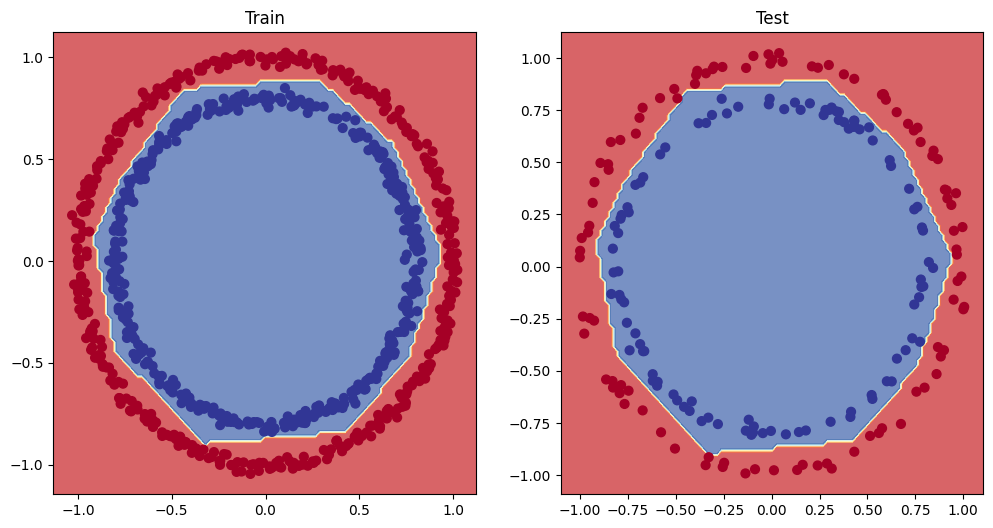

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Five_layer_model_NN, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Five_layer_model_NN, X_test, y_test)

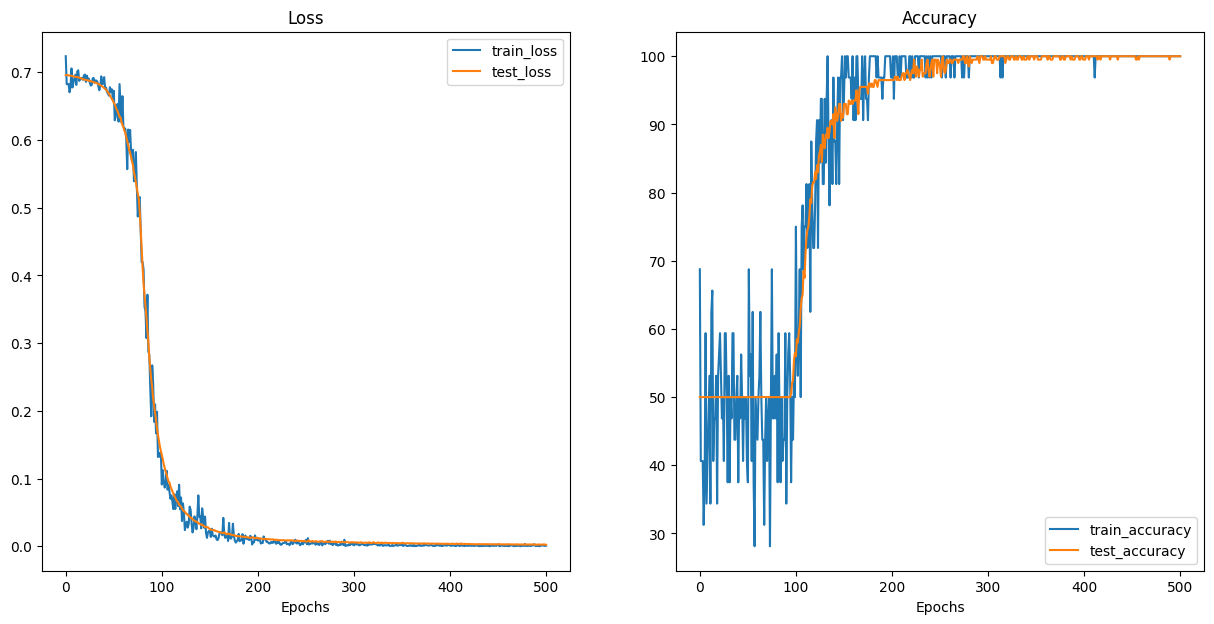

In [28]:
plot_loss_curves(results)

# What if we increse the noise?

In this final section the aim is to stress the model by increasing the gaussian noise of the generated data.

In [29]:
# Usefull for code readability
def Plot_Results(model_instance, X_train, y_train, noise, show: bool):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  if show:
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Decision Boundary & Loss Plot for noise = {noise}", fontsize = 14, fontweight="bold")
    # Plot Train Boundary
    plt.subplot(2, 2, 1)
    plt.title(f"Train  = {noise}")
    plot_decision_boundary(model_instance, X_train, y_train)

    # Plot Test Boundary
    plt.subplot(2, 2, 2)
    plt.title(f"Test with noise = {noise}")
    plot_decision_boundary(model_instance, X_test, y_test)

    # Plot loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


    plt.tight_layout()
    plt.show()

In [30]:
loss_fn = nn.BCEWithLogitsLoss()


--- Noise:  0.0  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.08763, Accuracy: 100.00% | Test Loss: 0.11311, Test Accuracy: 100.00%
Epoch: 200 | Loss: 0.00514, Accuracy: 100.00% | Test Loss: 0.00474, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00126, Accuracy: 100.00% | Test Loss: 0.00134, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00054, Accuracy: 100.00% | Test Loss: 0.00061, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00025, Accuracy: 100.00% | Test Loss: 0.00032, Test Accuracy: 100.00%




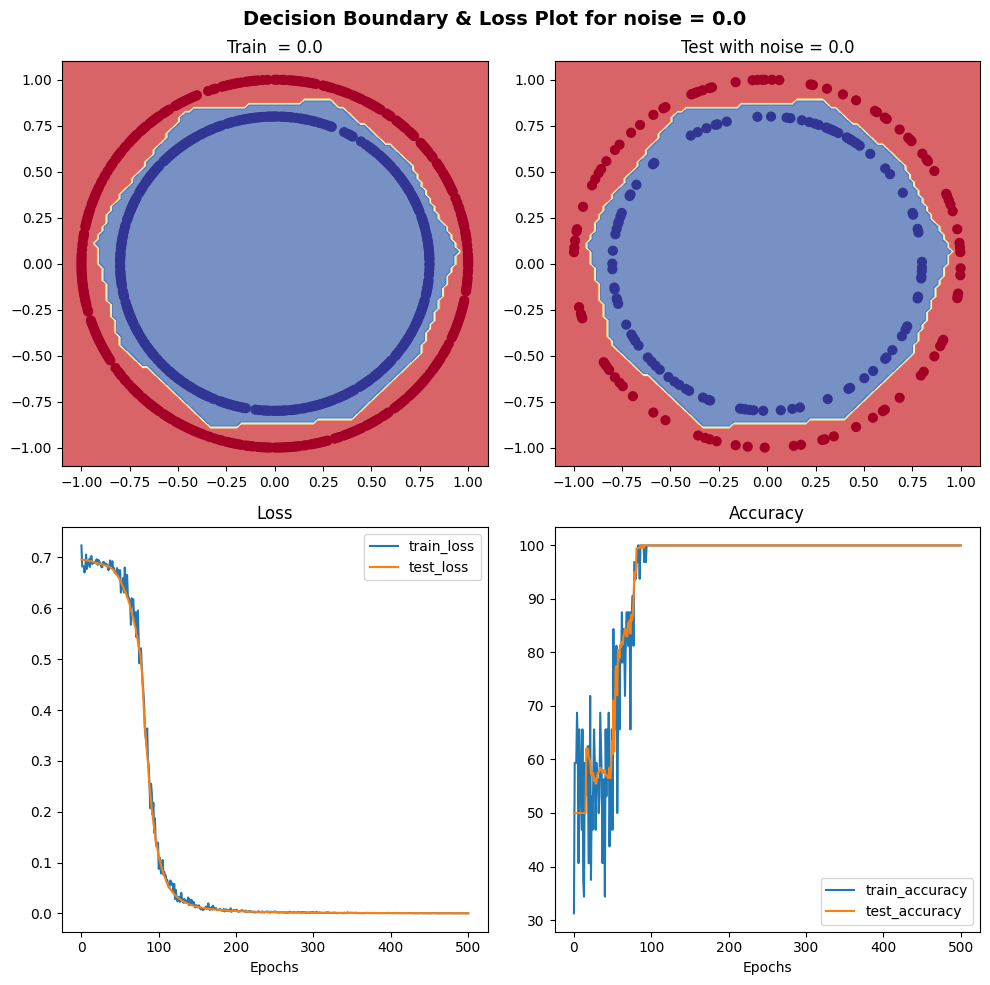


--- Noise:  0.01  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.08997, Accuracy: 100.00% | Test Loss: 0.12183, Test Accuracy: 100.00%
Epoch: 200 | Loss: 0.00557, Accuracy: 100.00% | Test Loss: 0.00635, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00142, Accuracy: 100.00% | Test Loss: 0.00222, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00070, Accuracy: 100.00% | Test Loss: 0.00114, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00041, Accuracy: 100.00% | Test Loss: 0.00065, Test Accuracy: 100.00%




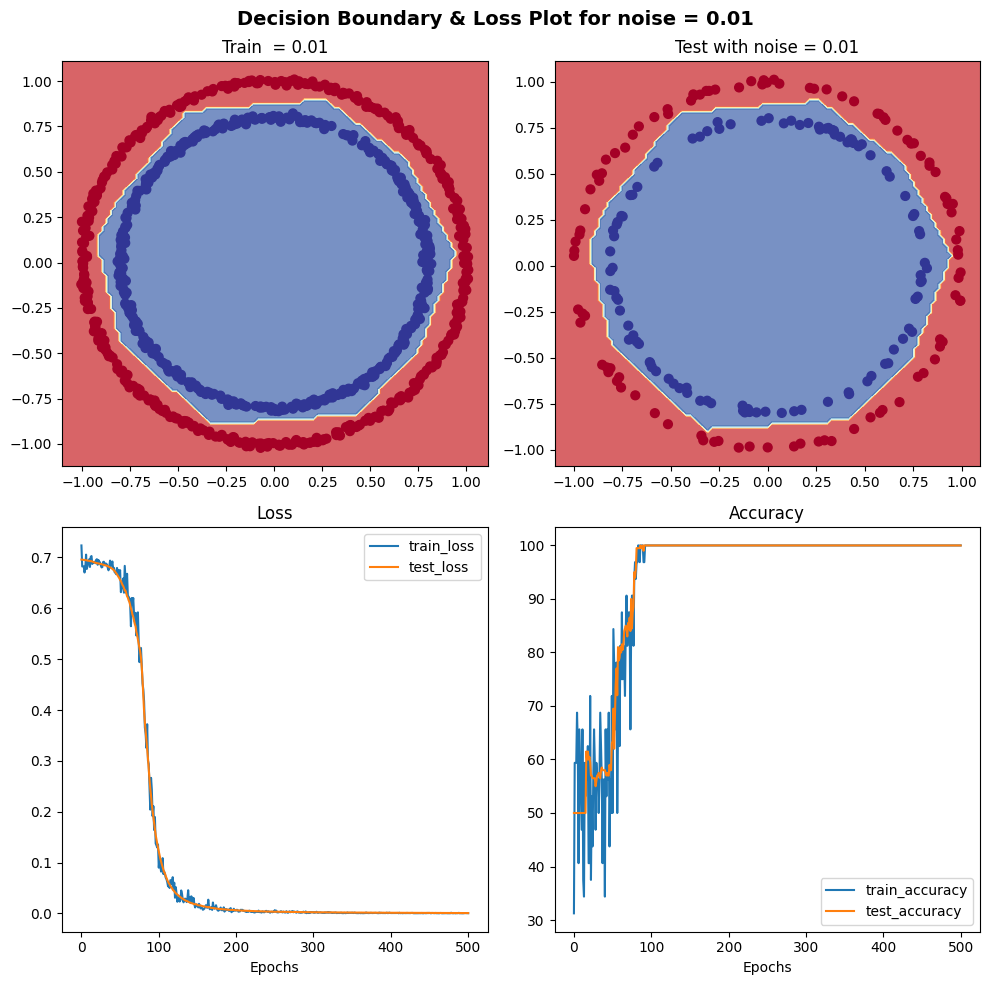


--- Noise:  0.02  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.09121, Accuracy: 100.00% | Test Loss: 0.13440, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.00844, Accuracy: 100.00% | Test Loss: 0.01243, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00143, Accuracy: 100.00% | Test Loss: 0.00580, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00120, Accuracy: 100.00% | Test Loss: 0.00336, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00106, Accuracy: 100.00% | Test Loss: 0.00224, Test Accuracy: 100.00%




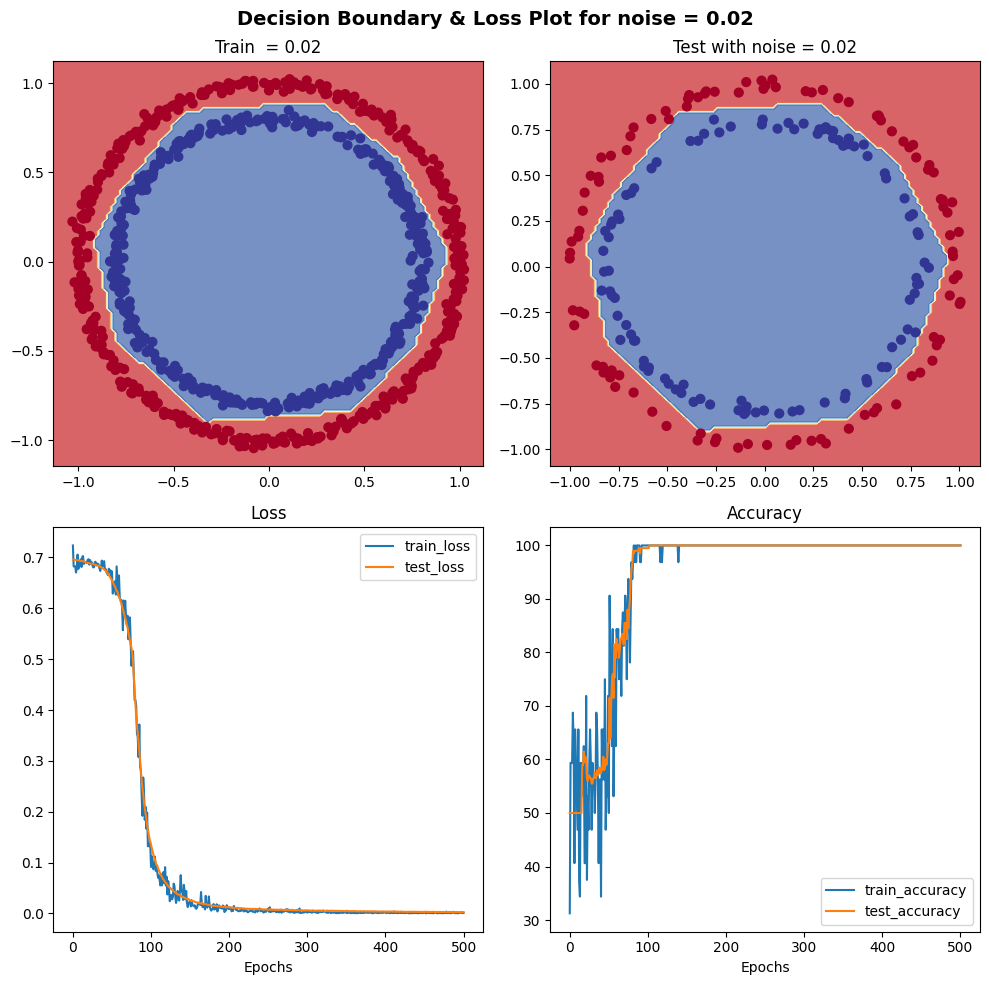


--- Noise:  0.03  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.09980, Accuracy: 100.00% | Test Loss: 0.15977, Test Accuracy: 98.50%
Epoch: 200 | Loss: 0.01621, Accuracy: 100.00% | Test Loss: 0.03547, Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.00258, Accuracy: 100.00% | Test Loss: 0.02801, Test Accuracy: 98.00%
Epoch: 400 | Loss: 0.00267, Accuracy: 100.00% | Test Loss: 0.02362, Test Accuracy: 98.50%
Epoch: 500 | Loss: 0.00161, Accuracy: 100.00% | Test Loss: 0.02616, Test Accuracy: 98.00%




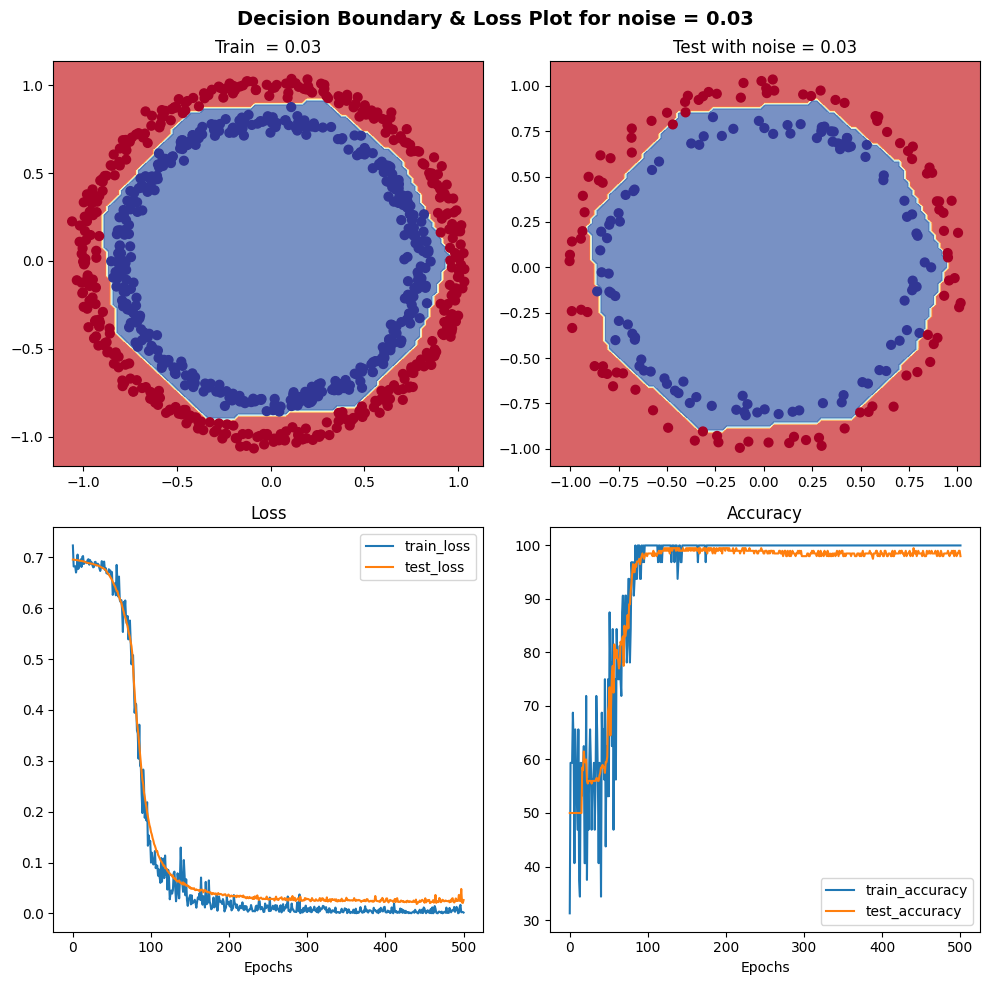


--- Noise:  0.04  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.11090, Accuracy: 100.00% | Test Loss: 0.19323, Test Accuracy: 96.00%
Epoch: 200 | Loss: 0.01999, Accuracy: 100.00% | Test Loss: 0.08088, Test Accuracy: 96.50%
Epoch: 300 | Loss: 0.00841, Accuracy: 100.00% | Test Loss: 0.08050, Test Accuracy: 97.00%
Epoch: 400 | Loss: 0.00578, Accuracy: 100.00% | Test Loss: 0.07283, Test Accuracy: 97.00%
Epoch: 500 | Loss: 0.01039, Accuracy: 100.00% | Test Loss: 0.08586, Test Accuracy: 96.50%




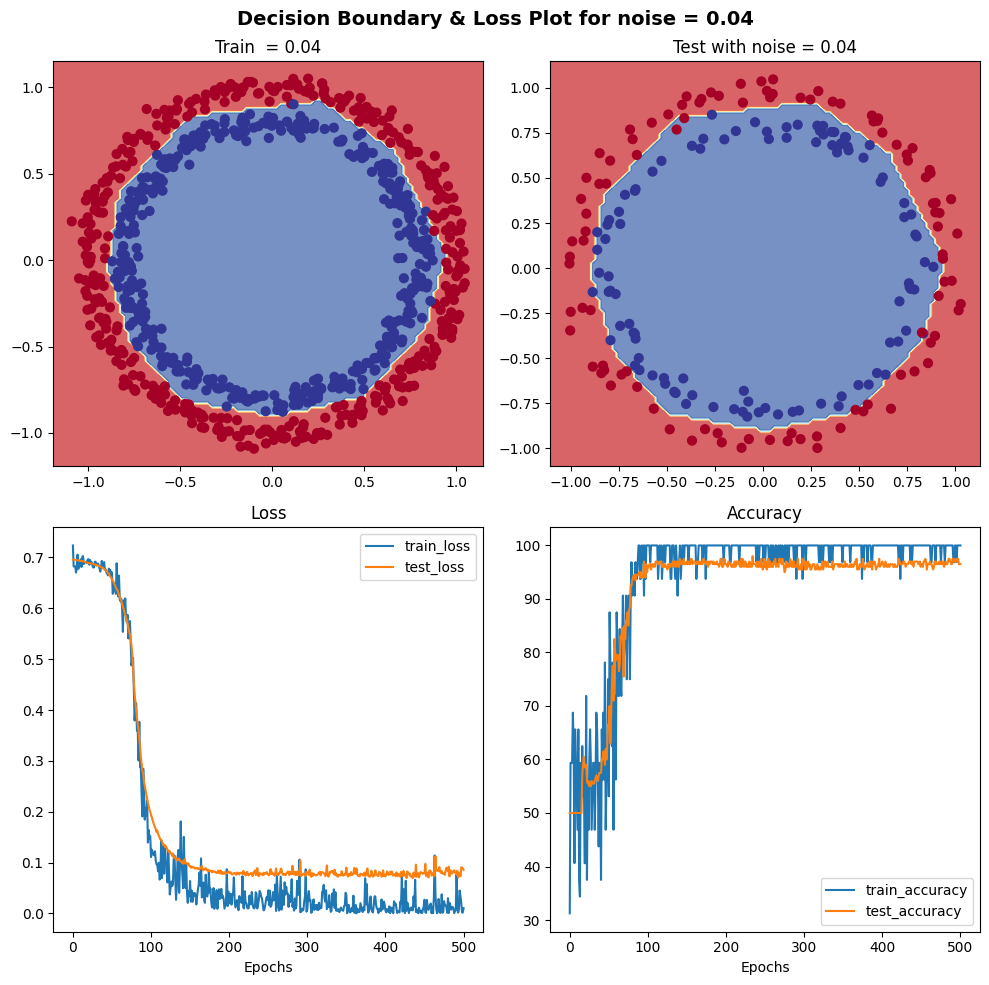


--- Noise:  0.05  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.13682, Accuracy: 96.88% | Test Loss: 0.24427, Test Accuracy: 92.50%
Epoch: 200 | Loss: 0.04884, Accuracy: 100.00% | Test Loss: 0.16441, Test Accuracy: 93.50%
Epoch: 300 | Loss: 0.03770, Accuracy: 96.88% | Test Loss: 0.16519, Test Accuracy: 93.50%
Epoch: 400 | Loss: 0.05556, Accuracy: 96.88% | Test Loss: 0.16467, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.10614, Accuracy: 93.75% | Test Loss: 0.17983, Test Accuracy: 92.50%




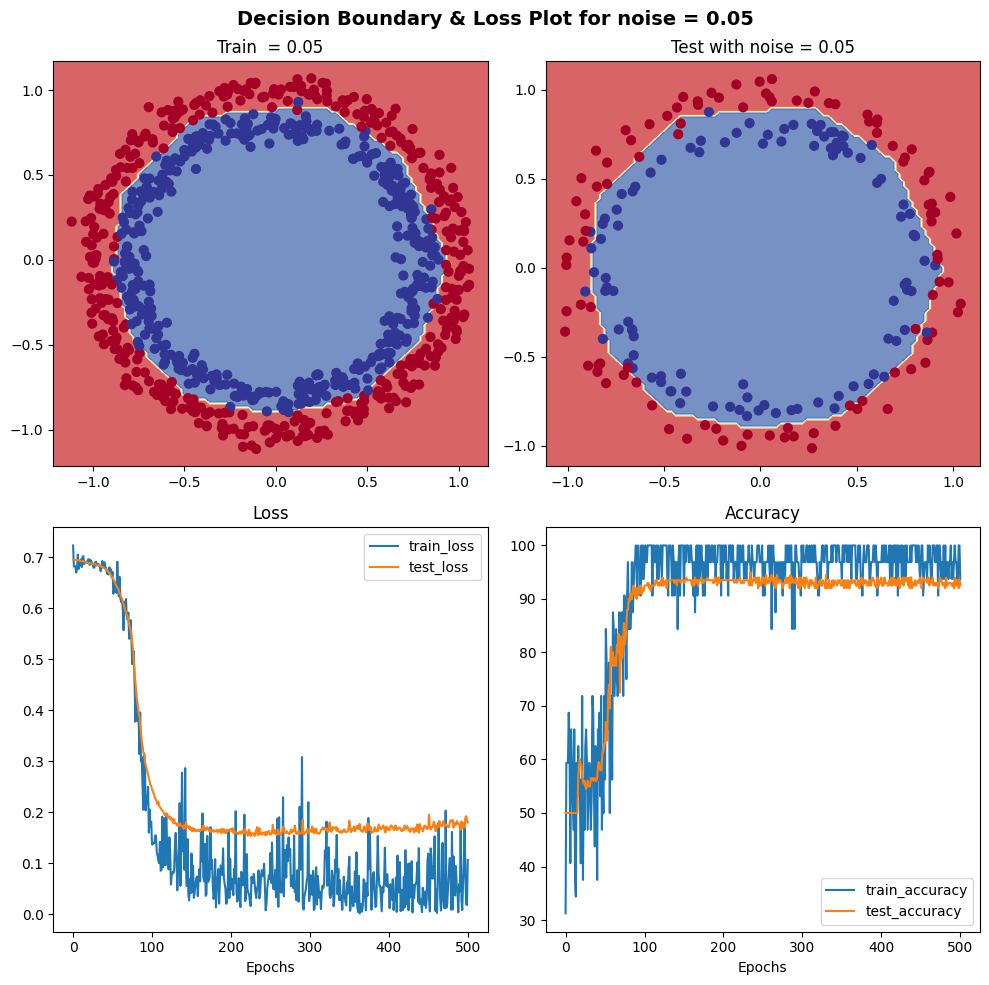


--- Noise:  0.06  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.17927, Accuracy: 93.75% | Test Loss: 0.30840, Test Accuracy: 88.50%
Epoch: 200 | Loss: 0.15356, Accuracy: 96.88% | Test Loss: 0.26790, Test Accuracy: 89.50%
Epoch: 300 | Loss: 0.09277, Accuracy: 96.88% | Test Loss: 0.27714, Test Accuracy: 90.00%
Epoch: 400 | Loss: 0.07249, Accuracy: 96.88% | Test Loss: 0.28727, Test Accuracy: 90.00%
Epoch: 500 | Loss: 0.14985, Accuracy: 93.75% | Test Loss: 0.29908, Test Accuracy: 88.00%




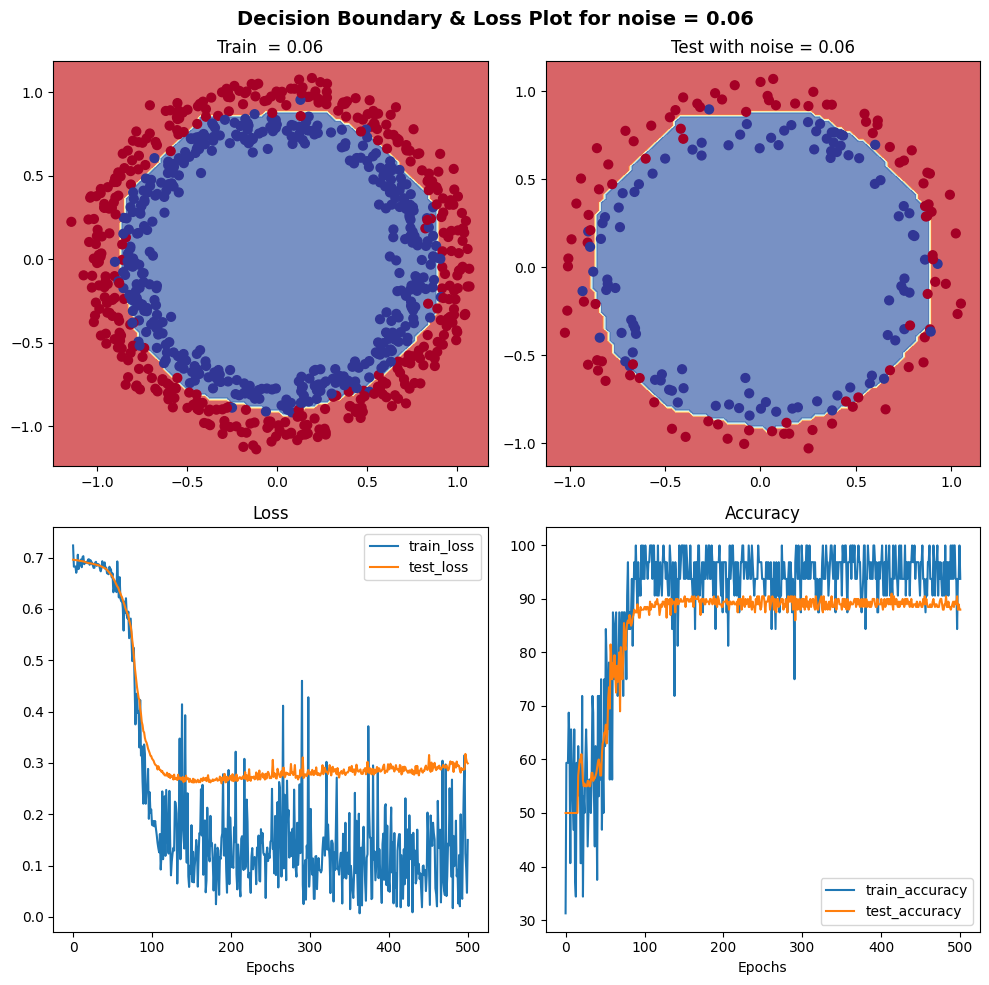


--- Noise:  0.07  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.23534, Accuracy: 87.50% | Test Loss: 0.37831, Test Accuracy: 86.00%
Epoch: 200 | Loss: 0.19809, Accuracy: 90.62% | Test Loss: 0.35620, Test Accuracy: 85.00%
Epoch: 300 | Loss: 0.14627, Accuracy: 96.88% | Test Loss: 0.35300, Test Accuracy: 85.00%
Epoch: 400 | Loss: 0.17386, Accuracy: 93.75% | Test Loss: 0.35168, Test Accuracy: 85.50%
Epoch: 500 | Loss: 0.30429, Accuracy: 84.38% | Test Loss: 0.36679, Test Accuracy: 85.00%




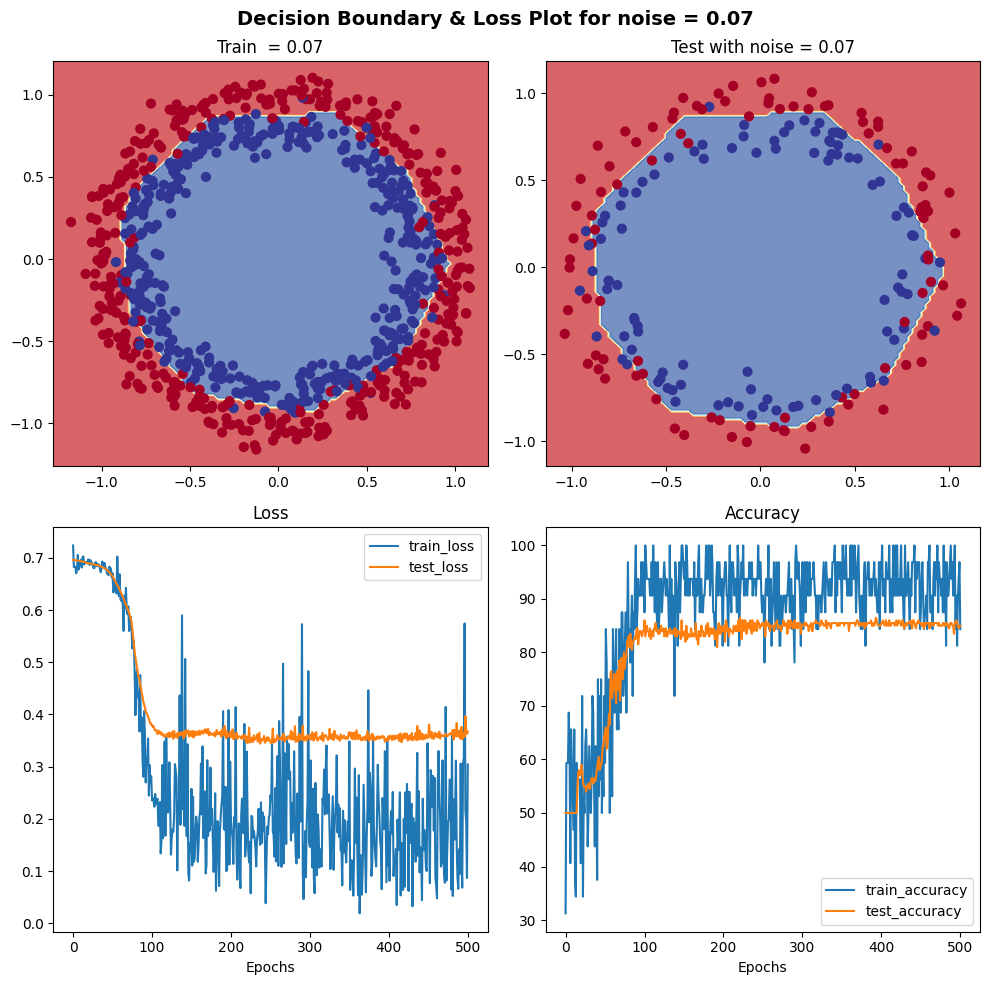


--- Noise:  0.08  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.26862, Accuracy: 87.50% | Test Loss: 0.43235, Test Accuracy: 80.00%
Epoch: 200 | Loss: 0.23073, Accuracy: 90.62% | Test Loss: 0.43662, Test Accuracy: 81.50%
Epoch: 300 | Loss: 0.19366, Accuracy: 96.88% | Test Loss: 0.44458, Test Accuracy: 82.00%
Epoch: 400 | Loss: 0.20557, Accuracy: 90.62% | Test Loss: 0.45306, Test Accuracy: 81.50%
Epoch: 500 | Loss: 0.35497, Accuracy: 87.50% | Test Loss: 0.47019, Test Accuracy: 81.50%




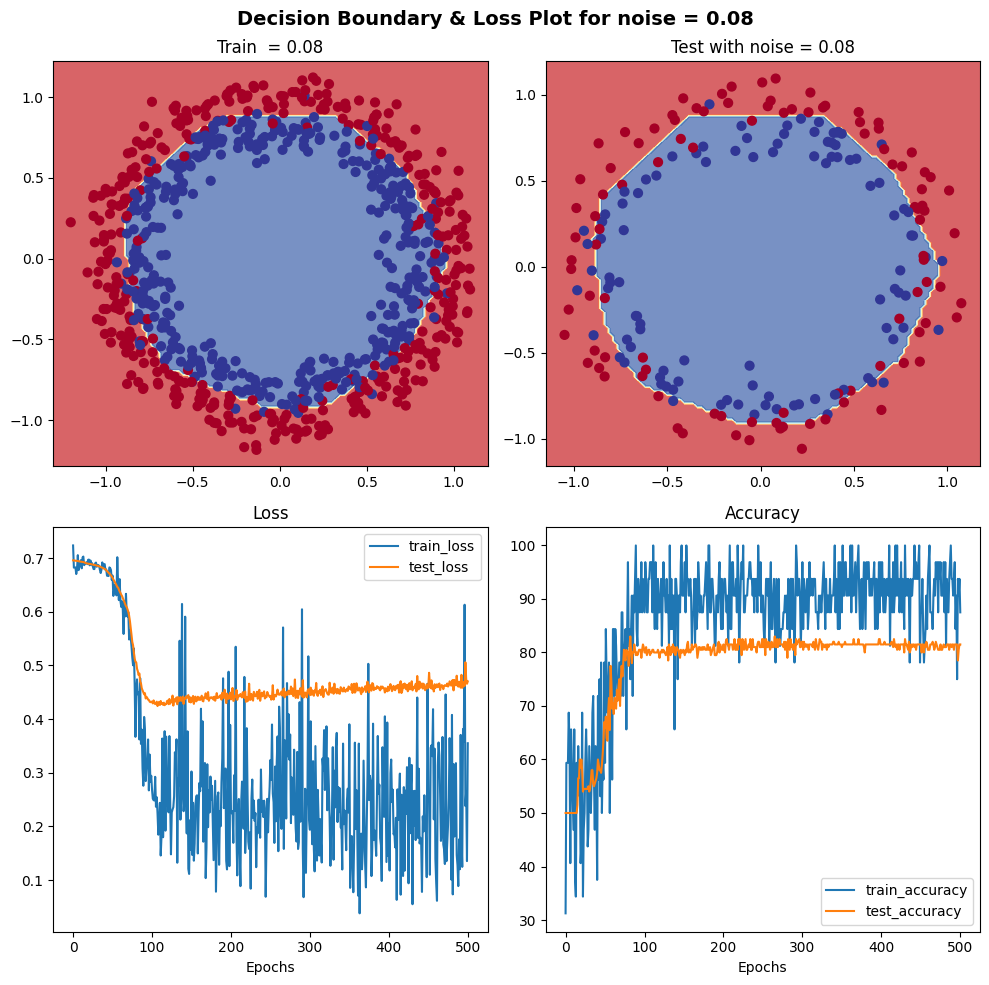


--- Noise:  0.09  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.29875, Accuracy: 87.50% | Test Loss: 0.48932, Test Accuracy: 75.50%
Epoch: 200 | Loss: 0.27997, Accuracy: 90.62% | Test Loss: 0.51990, Test Accuracy: 76.00%
Epoch: 300 | Loss: 0.26087, Accuracy: 87.50% | Test Loss: 0.52550, Test Accuracy: 77.00%
Epoch: 400 | Loss: 0.27151, Accuracy: 93.75% | Test Loss: 0.53647, Test Accuracy: 76.00%
Epoch: 500 | Loss: 0.42637, Accuracy: 81.25% | Test Loss: 0.54882, Test Accuracy: 75.50%




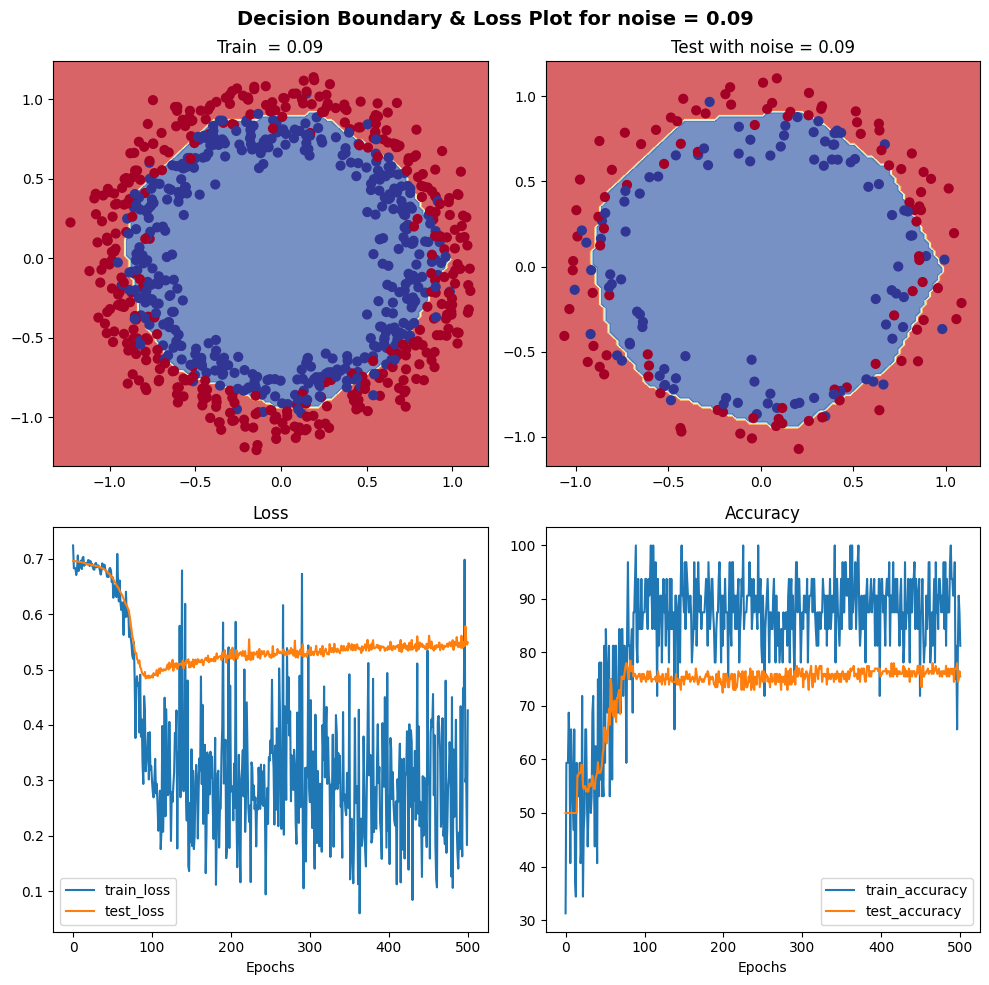


--- Noise:  0.1  ---
Epoch: 0 | Loss: 0.72365, Accuracy: 31.25% | Test Loss: 0.69586, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.34307, Accuracy: 84.38% | Test Loss: 0.53895, Test Accuracy: 71.00%
Epoch: 200 | Loss: 0.33219, Accuracy: 90.62% | Test Loss: 0.57695, Test Accuracy: 72.50%
Epoch: 300 | Loss: 0.30653, Accuracy: 81.25% | Test Loss: 0.57940, Test Accuracy: 73.50%
Epoch: 400 | Loss: 0.32826, Accuracy: 90.62% | Test Loss: 0.59076, Test Accuracy: 73.50%
Epoch: 500 | Loss: 0.46775, Accuracy: 81.25% | Test Loss: 0.60344, Test Accuracy: 73.00%




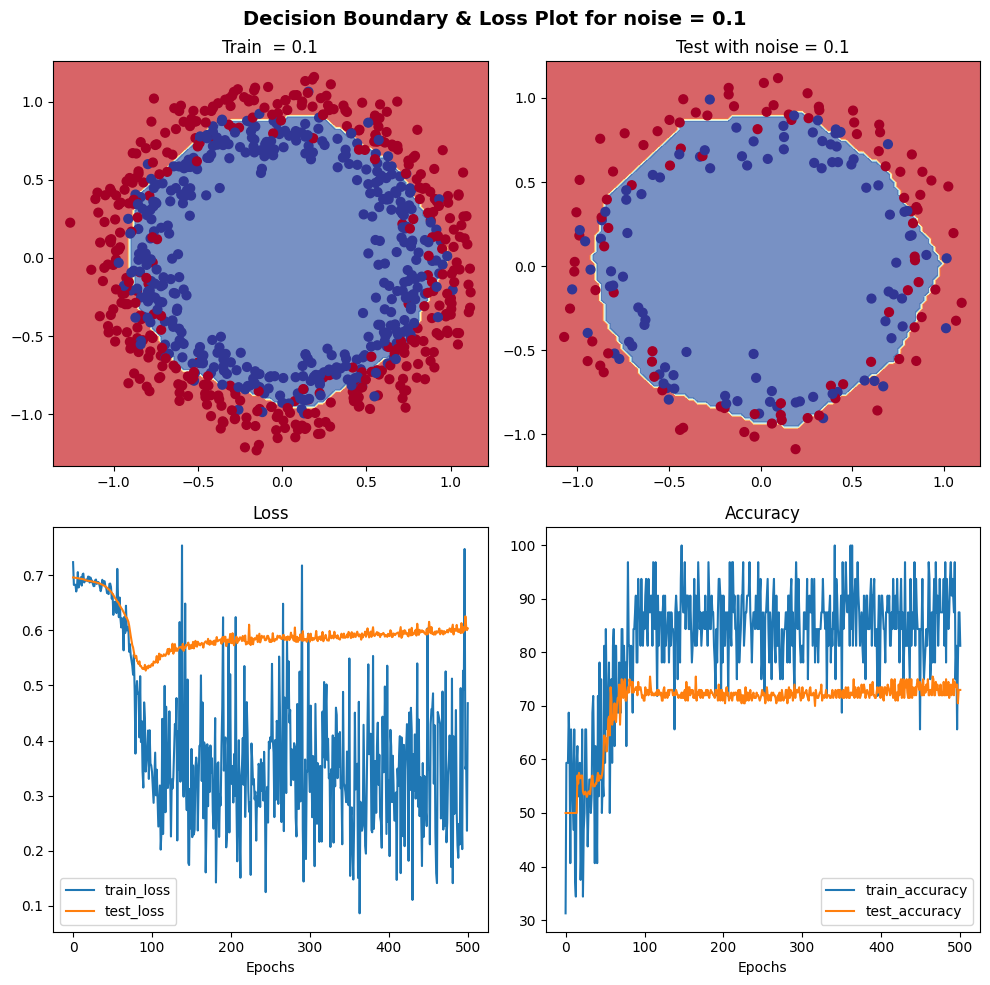

In [31]:
noise_range = np.arange(0, 0.11, 0.01)

for noise in noise_range:
  # Data Generation & Pre-Processing
  X, y = DataGeneration(n_samples = 1000, noise = float(noise), random_state = seed, plot = False)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

  X_train = torch.from_numpy(X_train).type(torch.float)
  y_train = torch.from_numpy(y_train).type(torch.float)

  X_test = torch.from_numpy(X_test).type(torch.float)
  y_test = torch.from_numpy(y_test).type(torch.float)

  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  batch_size = 128
  Dataset = torch.utils.data.TensorDataset(X_train, y_train)
  Dataset_loader = torch.utils.data.DataLoader(Dataset, batch_size = batch_size, shuffle = True)

  # Instantiate the Model & Inizialize the optimizer
  torch.manual_seed(42)
  Five_layer_model_NN = FeedForward_NN(input_units =  input_dimension,
                                      output_units = 1,
                                      hidden_units_1 = 3 * input_dimension,
                                      hidden_units_2 = 3 * input_dimension,
                                      hidden_units_3 = 2 * input_dimension,
                                      hidden_units_4 = 2 * input_dimension).to(device)

  optimizer = torch.optim.Adam(Five_layer_model_NN.parameters(), lr = 0.001)

  # Training Loop
  results = {'train_loss':[], 'train_acc': [], 'test_loss':[], 'test_acc': []}
  for epoch in range(epochs + 1):
    for X_train_batch, y_train_batch in Dataset_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

      # 1. Training Mode & Forward pass
      Five_layer_model_NN.train()
      y_logits = Five_layer_model_NN.forward(X_train_batch).squeeze() # Output of the forward method
      y_pred = torch.round(torch.sigmoid(y_logits))                   # logits > 0.5 -> predicted label = 1

      # 2. Calculate loss and accuracy
      loss = loss_fn(y_logits, y_train_batch)
      acc = accuracy_fn(y_true = y_train_batch, y_pred = y_pred)

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    ## Context Window for Testing to stop the evaluation of  parameters
    Five_layer_model_NN.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = Five_layer_model_NN(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    results['train_loss'].append(float(loss))
    results['train_acc'].append(float(acc))
    results['test_loss'].append(float(test_loss))
    results['test_acc'].append(float(test_acc))

    # Some "verbose"
    if epoch == 0 :
      print(f'\n--- Noise: ', noise,' ---')

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

  # Plots
  print('\n')
  Plot_Results(Five_layer_model_NN, X_train, y_train, noise, show = True)

Of course the training process should be better controlled to avoid overfitting which leads to bad generalization capabilities of the model, however this is not the purpose of our study.

# Exercises

Define a function which takes as input a **gaussian noise** and in output the behaviour of the model for different values of the **threshold** .

* **Suggestion** : Take advantage of the already written cells of code and merge them in a proper way.